# Introduction 

# About the Data

In [17]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("weather_classification_data.csv")

In [4]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [ ]:
df.describe()

# Humidity ranges from 20% to 109%, this is a due to the dataset being synthetic and the creator
# of the dataset not accounting for real world values. The same issue occurs with precipitation.
# Visibility has a minimum of 0, which also doesn't occur in real world conditions. UV index in the
# dataset ranges from 0 to 14. Real world UV range is from 1 to 11+ (with 12,13,14 being extremely unlikely).

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1005.827896,4.005758,5.462917
std,17.386327,20.194248,6.908704,31.946541,37.199589,3.856600,3.371499
min,-25.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,994.800000,1.000000,3.000000
50%,21.000000,70.000000,9.000000,58.000000,1007.650000,3.000000,5.000000
75%,31.000000,84.000000,13.500000,82.000000,1016.772500,7.000000,7.500000
max,109.000000,109.000000,48.500000,109.000000,1199.210000,14.000000,20.000000


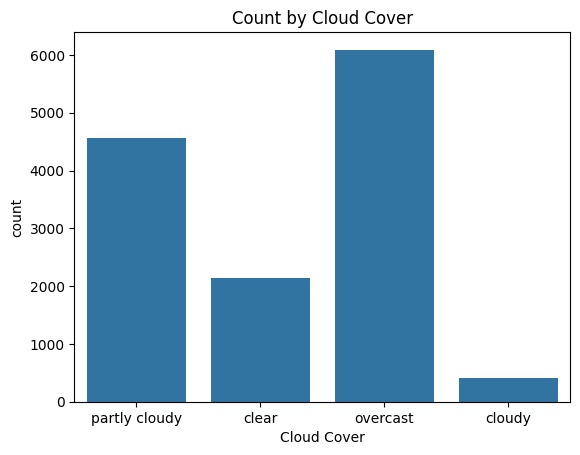

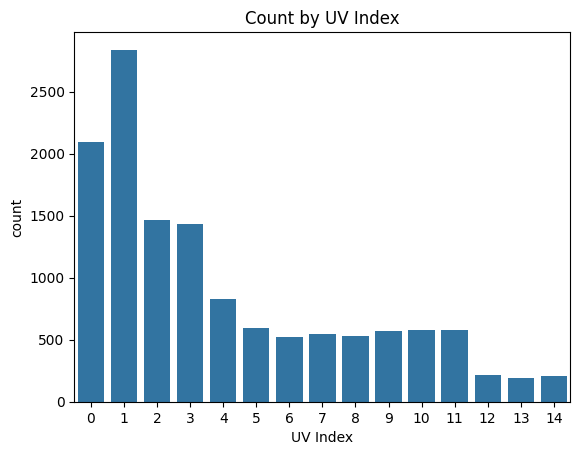

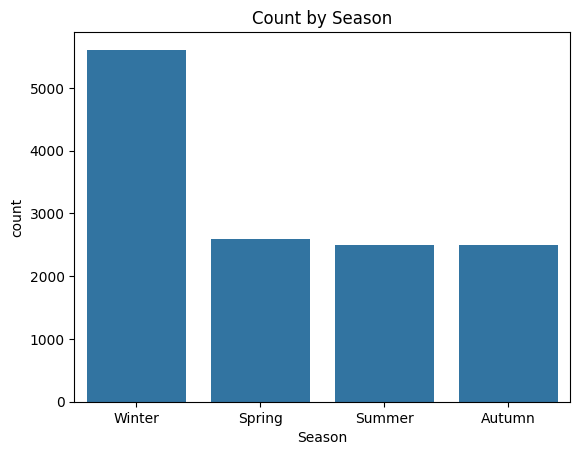

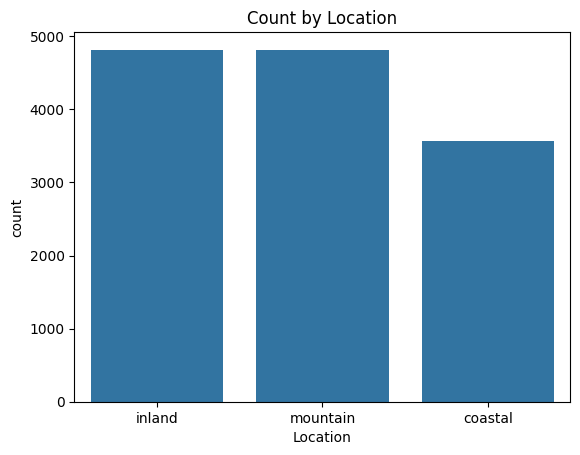

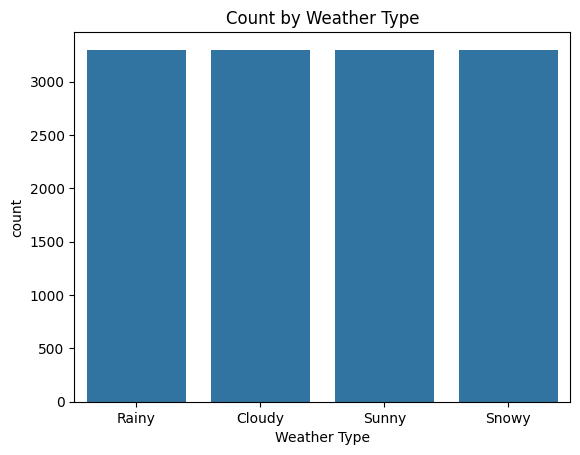

In [6]:
# plot distribution of discrete features

# Overcast conditions occurred most frequently, followed by partly cloudy, clear, and then cloudy skies.
# UV Index values are most commonly low, with frequency decreasing as the index increases.
# Winter had the highest observation count, while the other seasons had roughly equal and lower counts.
# Inland and mountain regions had similar and higher observation counts compared to coastal areas.
# All four weather types (Rainy, Cloudy, Sunny, and Snowy—had equal counts) showing a balanced distribution.

categorical_features = ['Cloud Cover', 'UV Index', 'Season', 'Location', 'Weather Type']

for cat in categorical_features:
    sns.countplot(data=df, x=cat)
    plt.title(f'Count by {cat}')
    plt.show()

# Pre-Processing

In [7]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(df[categorical_features])
encoded = encoder.transform(df[categorical_features])
column_names = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded, columns=column_names, index=df.index)
non_categorical = df.drop(columns=categorical_features)

# merge
processed_df = pd.concat([non_categorical, encoded_df], axis=1)

### Correcting issues with synthetic data
![Weatherman!](weatherman.png)

In [ ]:
# remove precipitations over 100%

processed_df = processed_df[processed_df["Precipitation (%)"] <= 100]
processed_df.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,...,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain,Weather Type_Cloudy,Weather Type_Rainy,Weather Type_Snowy,Weather Type_Sunny
count,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000,...,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000,12808.000000
mean,18.858760,68.065037,9.597556,52.072923,1005.818622,5.497658,0.161227,0.032089,0.460650,0.346034,...,0.198079,0.188476,0.424969,0.270690,0.364382,0.364928,0.249610,0.249141,0.250703,0.250547
std,16.996597,20.052603,6.613476,31.119669,37.704722,3.376084,0.367755,0.176244,0.498469,0.475723,...,0.398568,0.391107,0.494358,0.444334,0.481275,0.481429,0.432804,0.432533,0.433435,0.433345
min,-24.000000,20.000000,0.000000,0.000000,800.120000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,56.000000,5.000000,19.000000,994.697500,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,69.000000,8.500000,56.000000,1007.650000,5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,30.000000,83.000000,13.500000,80.000000,1016.810000,7.500000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,109.000000,109.000000,48.500000,100.000000,1199.210000,20.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
processed_df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,Visibility (km),Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,...,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain,Weather Type_Cloudy,Weather Type_Rainy,Weather Type_Snowy,Weather Type_Sunny
0,14.0,73,9.5,82.0,1010.82,3.5,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,39.0,96,8.5,71.0,1011.43,10.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,30.0,64,7.0,16.0,1018.72,5.5,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,38.0,83,1.5,82.0,1026.25,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,27.0,74,17.0,66.0,990.67,2.5,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [9]:
# count nulls
# data is synthetic so should be 0
processed_df.isnull().sum()

Temperature                  0
Humidity                     0
Wind Speed                   0
Precipitation (%)            0
Atmospheric Pressure         0
Visibility (km)              0
Cloud Cover_clear            0
Cloud Cover_cloudy           0
Cloud Cover_overcast         0
Cloud Cover_partly cloudy    0
UV Index_0                   0
UV Index_1                   0
UV Index_2                   0
UV Index_3                   0
UV Index_4                   0
UV Index_5                   0
UV Index_6                   0
UV Index_7                   0
UV Index_8                   0
UV Index_9                   0
UV Index_10                  0
UV Index_11                  0
UV Index_12                  0
UV Index_13                  0
UV Index_14                  0
Season_Autumn                0
Season_Spring                0
Season_Summer                0
Season_Winter                0
Location_coastal             0
Location_inland              0
Location_mountain            0
Weather 

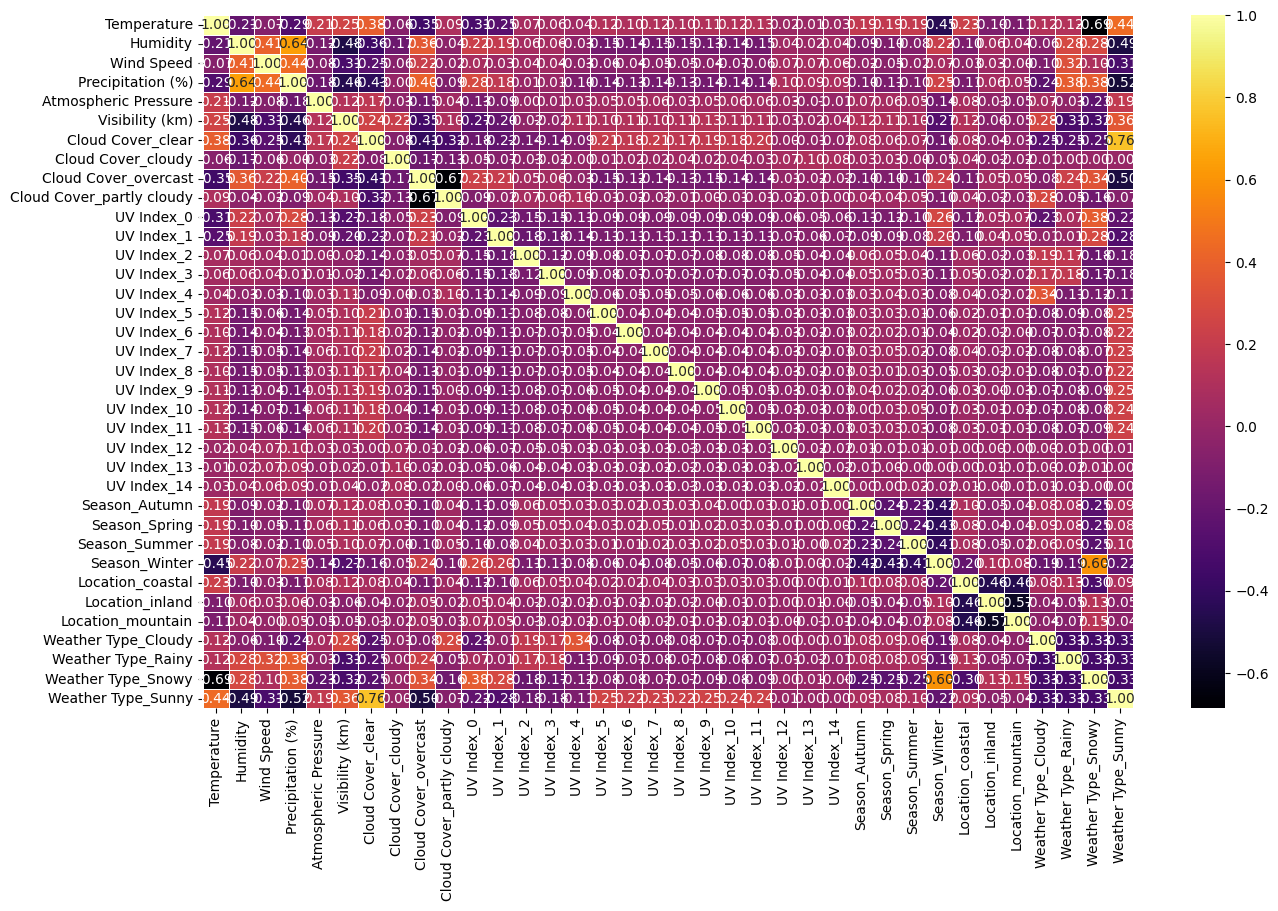

Top 10 highest (absolute) correlations:
Weather Type_Sunny         Cloud Cover_clear       0.761673
Weather Type_Snowy         Temperature             0.686025
Cloud Cover_partly cloudy  Cloud Cover_overcast    0.672356
Precipitation (%)          Humidity                0.638631
Weather Type_Snowy         Season_Winter           0.595813
Location_mountain          Location_inland         0.574146
Weather Type_Sunny         Precipitation (%)       0.518547
                           Cloud Cover_overcast    0.498186
                           Humidity                0.494751
Visibility (km)            Humidity                0.479969
dtype: float64


In [11]:
# generate a basic correlation matrix to visualize relationships
# the previous dataset I collected had essentially no correlation between features

correlation_matrix = processed_df.corr()
# Plot heatmap for better visualization
plt.figure(figsize=(15, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="inferno", fmt=".2f", linewidths=0.5)
plt.show()

# print 10 values with highest (absolute value) correlation
corr_abs = correlation_matrix.abs()
upper_triangle = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
top10 = upper_triangle.unstack().sort_values(ascending=False).head(10)

print("Top 10 highest (absolute) correlations:")
print(top10)

The correlations make logical sense, showing the dataset isn't completely random even though it's synthetic. This indicates we may be to train a useful model.

#  Methods 

#  Evaluation 

# Impact